# **Ноутбук экспериментов для задачи классификации на основе алгоритмов KNN**

Скачаем данные

In [1]:
import sys
sys.path.append('/kaggle/input/practicum-1')

from sklearn.datasets import fetch_openml
from nearest_neighbors import KNNClassifier
from cross_validation import knn_cross_val_score, kfold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = fetch_openml("mnist_784")

/opt/conda/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [2]:
X = np.array(data.data)
y = np.array(data.target)

In [3]:
X_train = X[:60000, :]
y_train = y[:60000]
X_test = X[60000: , :]
y_test = y[60000:]
del data
del X
del y

In [4]:
print(X_train.shape, X_test.shape)

(60000, 784) (10000, 784)


## **Эксперимент №1: Измерение времени работы различных алгоритмов**

Измерьте для каждого алгоритма поиска ('kd_tree', 'ball_tree', 'brute' и 'my_own') время нахождения 5
ближайших соседей для каждого объекта тестовой выборки по евклидовой метрике. Выберите подмножество признаков, по которому будет считаться расстояние, размера 10, 20, 100 (подмножество признаков
выбирается один раз для всех объектов, случайно). Проверьте все алгоритмы поиска ближайших соседей,
указанные в спецификации к заданию.

In [ ]:
import time


indices = np.arange(X_train.shape[1])

indexes = [np.random.choice(indices, size=size_i, replace=False) for size_i in [10, 20, 100]]

strategy_time = dict()
for strategy in ['kd_tree', 'ball_tree', 'brute', 'my_own']:
  model = KNNClassifier(k=5, strategy=strategy, metric='euclidean',
                        weights=False, test_block_size=10000)
  time_index = []
  for index in indexes:
    model.fit(X_train[:, index], y_train)
    start = time.time()
    model.find_kneighbors(X_test[:, index], return_distance=True)
    time_index.append(time.time()-start)
  strategy_time[strategy] = time_index

data_time_strategy = pd.DataFrame(data=strategy_time, index=['10', '20', '100'])

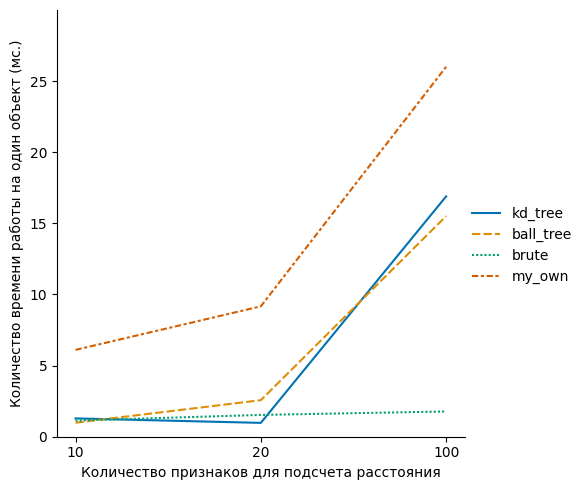

In [ ]:
sns.relplot(data=data_time_strategy, dashes=True, kind="line", palette="colorblind")
plt.xlabel("Количество признаков для подсчета расстояния")
plt.ylabel("Количество времени работы на один объект (мс.)")
plt.ylim(0, 300)
plt.yticks(ticks=[0, 50, 100, 150, 200, 250], labels=[0, 5, 10, 15, 20, 25])
plt.savefig(fname='exper_1.pdf')
plt.show()

# **Эксперимент №2: Измерение точности и времени работы в зависимости от k и метрики**

Оцените по кросс-валидации с 3 фолдами точность (долю правильно предсказанных ответов) и время работы k ближайших соседей в зависимости от следующих факторов:

*   k от 1 до 10 (только влияние на точность).
*   Используется евклидова или косинусная метрика.


Дайте ответ на следующие вопросы: \\

*   Какая метрика лучше себя показала в экспериментах? Можете ли вы объяснить, почему?
*   Есть ли на графике зависимости точности от количество соседей выбросы, резкие падения/повышения качества для одного значения k по сравнению с соседними? Если да, предположите причину появления этих выбросов.

In [54]:
score_metric = dict()
for metric in ['euclidean', 'cosine']:
  score_metric[metric] = knn_cross_val_score(X=X_train, y=y_train, k_list=range(1, 11),
                                     score="accuracy", cv=kfold(X_train.shape[0], 3),
                                     metric=metric, test_block_size=20000,
                                     weights=False, strategy='brute')

In [56]:
import time

score_time = dict()

for metric in ['euclidean', 'cosine']:
  score_time[metric] = dict()

  for k in [1, 2, 3]:
    model = KNNClassifier(k=k, metric=metric, test_block_size=10000,
                                      weights=False, strategy='brute')
    score_list = []
    cv=kfold(X_train.shape[0], 3)

    for fold in cv:
        X_train_1 = X_train[fold[0], :]
        y_train_1 = y_train[fold[0]]
        model.fit(X_train_1, y_train_1)

        start = time.time()
        y_pred = model.predict(X_train[fold[1], :])
        score_list.append(time.time() - start)

    score_time[metric][k] = np.array(score_list).mean()

In [57]:
accuracy_exp2 = {metric: {k: np.mean(v) for k, v in values.items()} for metric, values in score_metric.items()}
accuracy_exp2 = pd.DataFrame(accuracy_exp2)
accuracy_exp2.index.name = 'k'

time_exp2 = {metric: {k: np.mean(v) for k, v in values.items()} for metric, values in score_time.items()}
time_exp2 = pd.DataFrame(time_exp2)
time_exp2.index.name = 'k'

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


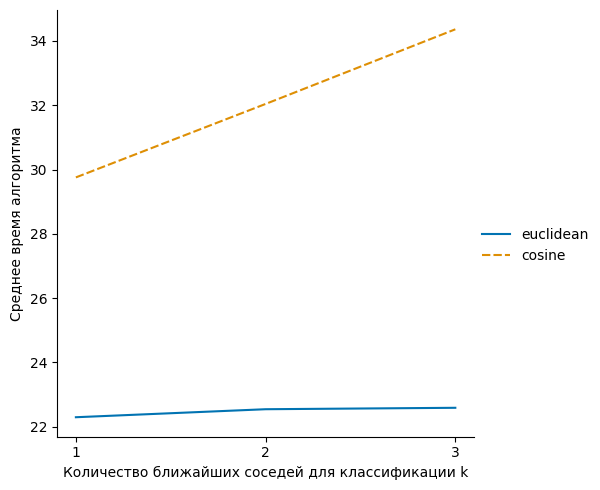

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


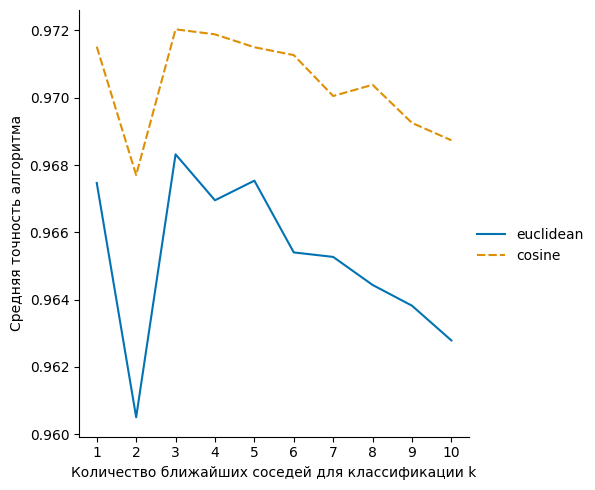

In [59]:
sns.relplot(data=time_exp2, dashes=True, kind="line", palette="colorblind")
plt.xlabel("Количество ближайших соседей для классификации k")
plt.ylabel("Среднее время алгоритма")
plt.xticks([1, 2, 3])
plt.savefig(fname='exper_2_time.pdf')

plt.show()

sns.relplot(data=accuracy_exp2, dashes=True, kind="line", palette="colorblind")
plt.xlabel("Количество ближайших соседей для классификации k")
plt.ylabel("Средняя точность алгоритма")
plt.xticks(range(1, 11))
plt.savefig(fname='exper_2_acc.pdf')
plt.show()

# **Эксперимент №3: Сравнение KNN с весами и без весов**

Сравните взвешенный метод k ближайших соседей, где голос объекта равен 1/(distance + ε), где ε — 10−5
,
с методом без весов при тех же фолдах и параметрах.

In [60]:
score_w = dict()

score_w['weight'] = knn_cross_val_score(X=X_train, y=y_train, k_list=range(1, 6),
                                     score="accuracy", cv=kfold(X_train.shape[0], 3),
                                     metric='cosine', test_block_size=20000,
                                     weights=True, strategy='brute')

score_w['not weight'] = knn_cross_val_score(X=X_train, y=y_train, k_list=range(1, 6),
                                     score="accuracy", cv=kfold(X_train.shape[0], 3),
                                     metric='cosine', test_block_size=20000,
                                     weights=False, strategy='brute')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


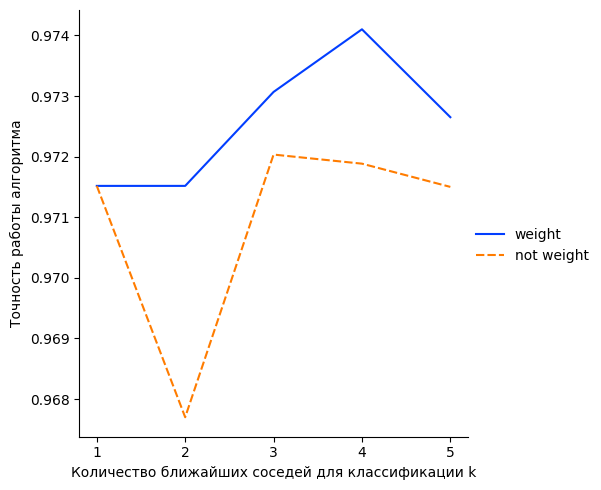

In [61]:
accuracy_exp3 = {metric: {k: np.mean(v) for k, v in values.items()} for metric, values in score_w.items()}
accuracy_exp3 = pd.DataFrame(accuracy_exp3)
accuracy_exp3.index.name = 'k'


sns.relplot(data=accuracy_exp3, dashes=True, kind="line", palette="bright")
plt.xlabel("Количество ближайших соседей для классификации k")
plt.ylabel("Точность работы алгоритма")
plt.xticks(range(1, 6))
plt.savefig(fname='exper_3_acc.pdf')

plt.show()

# **Эксперимент №4: Оценка лучшего алгоритма KNN и анализ ошибок**

Примените лучший алгоритм к исходной обучающей и тестовой выборке. Подсчитайте точность. Сравните с точностью по кросс-валидации. Сравните с указанной в интернете точностью лучших алгоритмов на данной выборке. Выполните анализ ошибок. Для этого необходимо построить и проанализировать матрицу ошибок (confusion matrix). Также визуализируйте несколько объектов из тестовой выборки, на которых были допущены ошибки. Проанализируйте и укажите их общие черты

## **Оценка лучшего алгоритма**

In [5]:
model = KNNClassifier(k=4, strategy='brute', weights=True,
                      metric='cosine', test_block_size=10000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Accuracy = {np.sum(y_pred == y_test)/len(y_test)}")

Accuracy = 0.9752


## **Анализ ошибок**

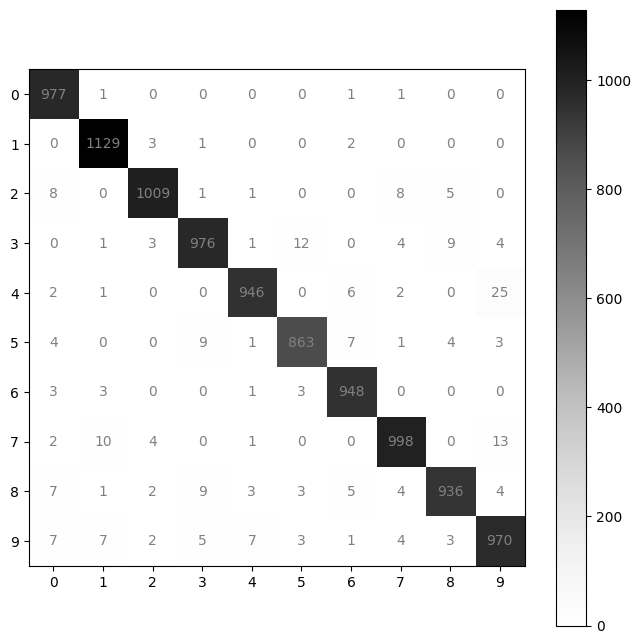

In [6]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,8))
plt.subplot(1, 1, 1)
plt.imshow(conf_matrix, cmap="Greys")

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='grey')

plt.xticks(range(0, 10))
plt.yticks(range(0, 10))
plt.colorbar()
plt.savefig(fname='exper_4_conf.pdf')
plt.show()

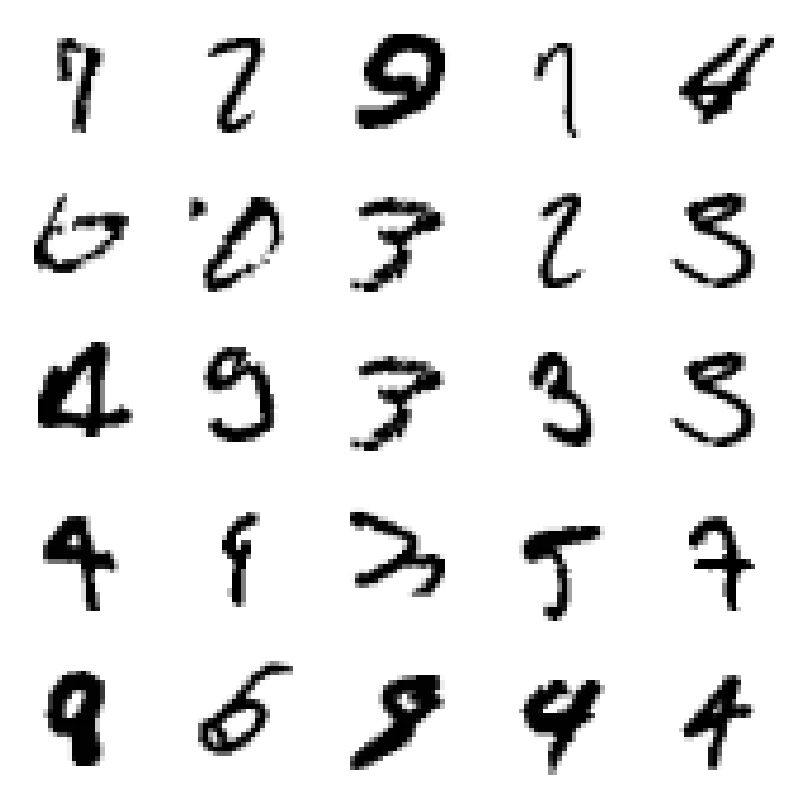

In [10]:
error_images = X_test[y_pred != y_test]

random_errors = error_images[np.random.randint(0, len(error_images), 25)]

fig, axes = plt.subplots(5, 5, figsize=(10, 10))


for i, ax in enumerate(axes.flat):
    ax.imshow(random_errors[i].reshape(28, 28), cmap='gray_r')
    ax.axis('off')

plt.savefig(fname='exper_4_numb.pdf')
plt.show()

 # **Эксперимент №5: Выполнение аугментаций и их анализ для исправления ошибок**

Выполните аугментацию обучающей выборки. Для этого нужно размножить ее с помощью поворотов, смещений, морфологических операций и применений гауссовского фильтра. Разрешается использовать библиотеки для работы с изображениями. Подберите по кросс-валидации с 3 фолдами параметры преобразований. Рассмотрите следующие параметры для преобразований и их комбинации:


1.  Величина поворота: 5, 10, 15 (в каждую из двух сторон)
2.  Величина смещения: 1, 2, 3 пикселя (по каждой из двух размерностей)
3.  Дисперсия фильтра Гаусса: 0.5, 1, 1.5
4.  Морфологические операции: эрозия, дилатация, открытие, закрытие с ядром 2 (https://docs.opencv.org/3.4/d9/d61/tutorial_py_morphological_ops.html)

Проанализируйте, как изменилась матрица ошибок, какие ошибки алгоритма помогает исправить каждое
преобразование.

In [5]:
import skimage.io
import skimage.color
import skimage.transform
import scipy.ndimage
import tqdm

In [6]:
def knn_value_score_augment(X: np.ndarray, y: np.ndarray, k_list: list,
                        score: str, augment_func = None, cv: list = None, **kwargs):
    if cv is None:
        cv = kfold(X.shape[0], 3)

    def accuracy(y_pred, y_test):
        return np.sum(y_pred == y_test)/len(y_test)

    if score == 'accuracy':
        function_score = accuracy

    model = KNNClassifier(k=k_list[-1], **kwargs)
    score_dict = {k: np.zeros(len(cv), dtype=float) for k in k_list}

    for i, fold in enumerate(cv):
        X_train = np.concatenate((np.apply_along_axis(augment_func, arr=X[fold[0], :], axis=1), X[fold[0], :]), axis=0) 
        y_train = np.concatenate((y[fold[0]], y[fold[0]]), axis=0) 

        model.fit(X_train, y_train)

        X_test = X[fold[1], :]
        y_test = y[fold[1]]

        get_value_index = np.vectorize(lambda x: y_train[x])

        if model.weights:
            distance_matrix, index_matrix = model.find_kneighbors(
                X_test, return_distance=True)
            value_matrix = get_value_index(index_matrix)
            del index_matrix

            weights = 1 / (distance_matrix + 10**(-5))
            del distance_matrix

            for k in k_list:
                predicted_classes = []

                for value_row, weight_row in zip(
                        value_matrix[:, :k], weights[:, :k]):
                    values = np.unique(value_row)
                    weighted_voices = []
                    for value in values:
                        sum_weights = np.sum(
                            weight_row[value_row == value])
                        weighted_voices.append(sum_weights)

                    weighted_voices = np.array(weighted_voices)
                    predicted_classes.append(
                        values[np.argmax(weighted_voices)])

                y_pred = np.array(predicted_classes)

                del predicted_classes

                if score == 'accuracy':
                    score_dict[k][i] = function_score(y_pred, y_test)
        else:
            index_matrix = model.find_kneighbors(
                X_test, return_distance=False)

            value_matrix = get_value_index(index_matrix)
            del index_matrix

            def predict_class_in_row(row):
                values, counts = np.unique(row, return_counts=True)
                index_class = np.argmax(counts)
                return values[index_class]

            for k in k_list:
                predicted_classes = np.apply_along_axis(
                    predict_class_in_row, axis=1, arr=value_matrix[:, :k])

                y_pred = predicted_classes
                del predicted_classes

                if score == 'accuracy':
                    score_dict[k][i] = function_score(y_pred, y_test)

    return score_dict

## **Преобразование - поворот**

In [24]:
from skimage.transform import rotate

angles_array = [-15, -10, -5, 5, 10, 15]
dict_angles = dict()

for angle in tqdm.tqdm(angles_array):
  dict_angles[angle] = knn_value_score_augment(X_train, y_train, k_list=[4], 
                                           augment_func = (lambda x: rotate(x.reshape(28, 28), angle=angle).reshape(784)),
                                           score='accuracy', strategy='brute', weights=True,
                                           metric='cosine', test_block_size=10000)

100%|██████████| 6/6 [25:17<00:00, 252.86s/it]


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


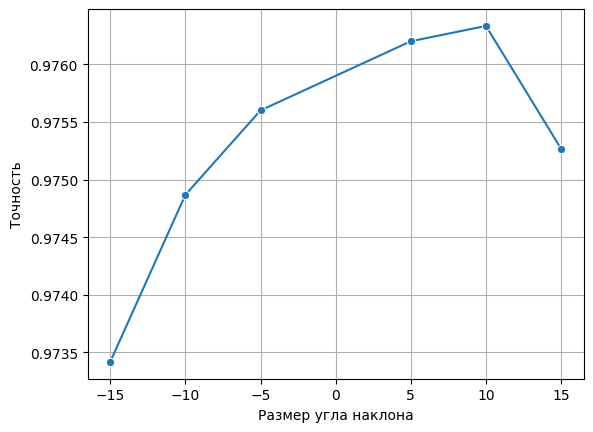

In [25]:
accuracy_exp5 = {angle: {k: np.mean(v) for k, v in values.items()} for angle, values in dict_angles.items()}
accuracy_exp5 = pd.DataFrame(accuracy_exp5)
accuracy_exp5.index.name = 'k'

accuracies = accuracy_exp5.iloc[0]
angles = accuracy_exp5.columns
sns.lineplot(x=angles, y=accuracies, marker='o')
plt.xlabel('Размер угла наклона')
plt.ylabel('Точность')

plt.grid(True)
plt.savefig(fname='exper_5_angles.pdf')
plt.show()

## **Преобразование - смещение**

In [7]:
from skimage.transform import warp, AffineTransform
trans = [-3, -2, -1, 0, 1, 2, 3]

dict_trans = dict()

for trans_v in tqdm.tqdm(trans):
    for trans_h in tqdm.tqdm(trans):
        dict_trans[(trans_v, trans_h)] = knn_value_score_augment(X_train, y_train, k_list=[4],
                                           augment_func = (lambda x: warp(x.reshape(28, 28),
                                                                          AffineTransform(translation=(trans_h, trans_v))).reshape(784)),
                                           score='accuracy', strategy='brute', weights=True,
                                           metric='cosine', test_block_size=10000)

100%|██████████| 7/7 [3:23:51<00:00, 1747.30s/it]


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


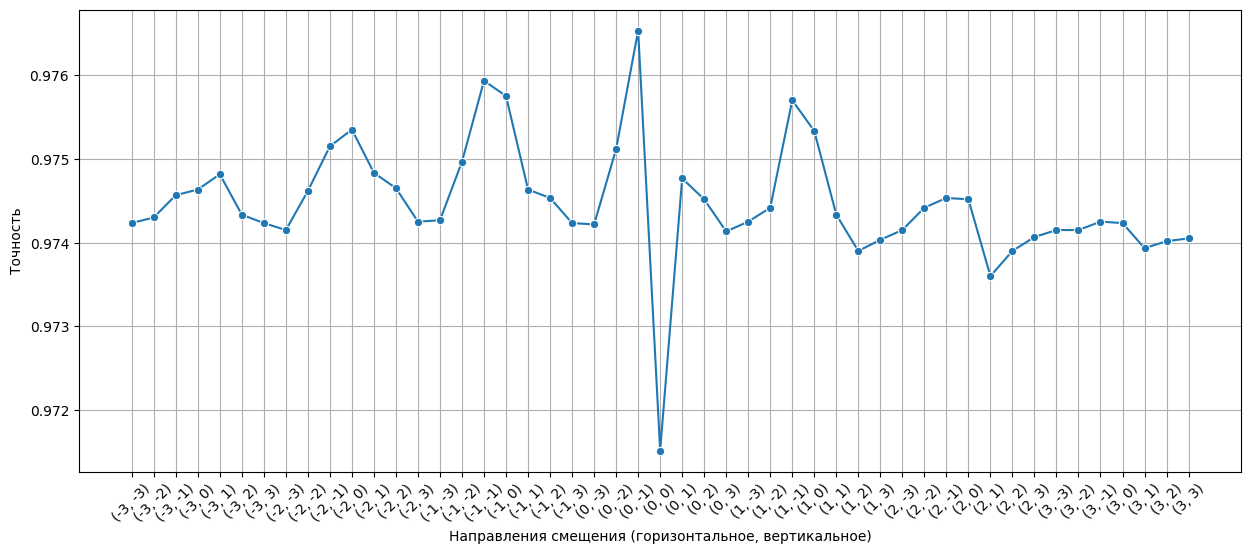

In [15]:
accuracy_exp5 = {str(disp): {k: np.mean(v) for k, v in values.items()} for disp, values in dict_trans.items()}
accuracy_exp5 = pd.DataFrame(accuracy_exp5)
accuracy_exp5.index.name = 'k'

accuracies = accuracy_exp5.iloc[0]
disps = accuracy_exp5.columns
plt.figure(figsize=(15, 6))
sns.lineplot(x=disps, y=accuracies, marker='o')
plt.xlabel('Направления смещения (горизонтальное, вертикальное)')
plt.ylabel('Точность')
plt.xticks(rotation=45)

plt.grid(True)
plt.savefig(fname='exper_5_trans.pdf')
plt.show()

## **Преобразование - дисперсия фильтра Гаусса**

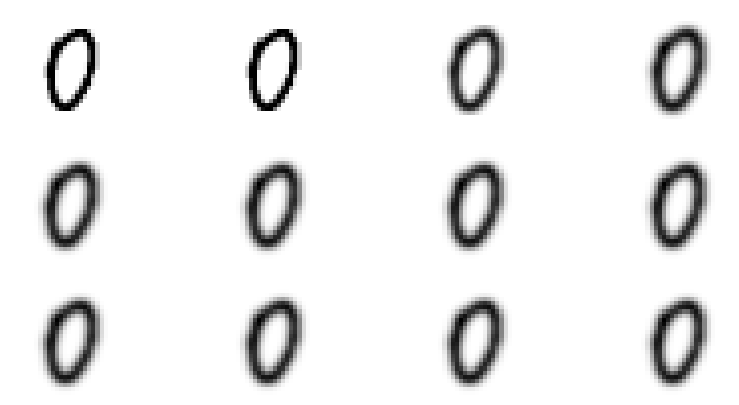

In [16]:
import cv2 as cv

fig, axes = plt.subplots(3, 4, figsize=(10, 5))



for i, ax in enumerate(axes.flat):
    if i == 0:
        ax.imshow(X_train[1000].reshape(28, 28), cmap='gray_r')
    else:
        ax.imshow(cv.GaussianBlur(
            X_train[1000].reshape(28, 28), (i*2-1, i*2-1), sigmaX=1), cmap='gray_r')
    ax.axis('off')

plt.savefig(fname='exper_5_gauss.pdf')


plt.show()

In [26]:
import cv2 as cv

gauss_filter = [0.5, 1.0, 1.5]
dict_gauss = dict()

for disp in tqdm.tqdm(gauss_filter):
  dict_gauss[disp] = knn_value_score_augment(X_train, y_train, k_list=[4],
                                           augment_func = (lambda x: cv.GaussianBlur(x.reshape(28, 28), (3, 3), sigmaX=disp).reshape(784)),
                                           score='accuracy', strategy='brute', weights=True,
                                           metric='cosine', test_block_size=10000)

100%|██████████| 3/3 [11:09<00:00, 223.16s/it]


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


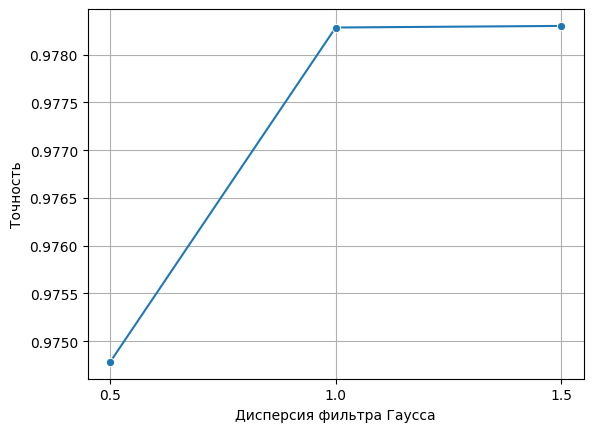

In [43]:
accuracy_exp5 = {disp: {k: np.mean(v) for k, v in values.items()} for disp, values in dict_gauss.items()}
accuracy_exp5 = pd.DataFrame(accuracy_exp5)
accuracy_exp5.index.name = 'k'

accuracies = accuracy_exp5.iloc[0]
disps = accuracy_exp5.columns
sns.lineplot(x=disps, y=accuracies, marker='o')
plt.xlabel('Дисперсия фильтра Гаусса')
plt.ylabel('Точность')
plt.xticks(gauss_filter)
plt.grid(True)
plt.savefig(fname='exper_5_gauss_2.pdf')
plt.show()

## **Преобразование - эрозия**

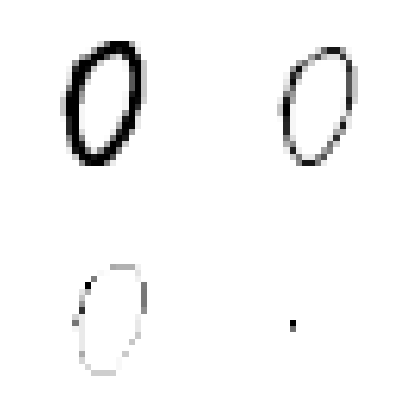

In [31]:
import cv2 as cv

fig, axes = plt.subplots(2, 2, figsize=(5, 5))

kernel = np.ones((2, 2), np.uint8)

for i, ax in enumerate(axes.flat):
    if i == 0:
        ax.imshow(X_train[1000].reshape(28, 28), cmap='gray_r')
    else:
        ax.imshow(cv.erode(X_train[1000].reshape(28, 28), kernel, iterations = i), cmap='gray_r')
    ax.axis('off')

plt.savefig(fname='exper_5_erode.pdf')


plt.show()

In [33]:
import cv2 as cv

dict_erode = dict()

kernel = np.ones((2, 2), np.uint8)
for iteration in tqdm.tqdm(range(1, 4)):
    dict_erode[iteration] = knn_value_score_augment(X_train, y_train, k_list=[4],
                                           augment_func = (lambda x: (cv.erode(x.reshape(28, 28), kernel, iterations = iteration).reshape(784))),
                                           score='accuracy', strategy='brute', weights=True,
                                           metric='cosine', test_block_size=10000)
    

100%|██████████| 3/3 [11:04<00:00, 221.65s/it]


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


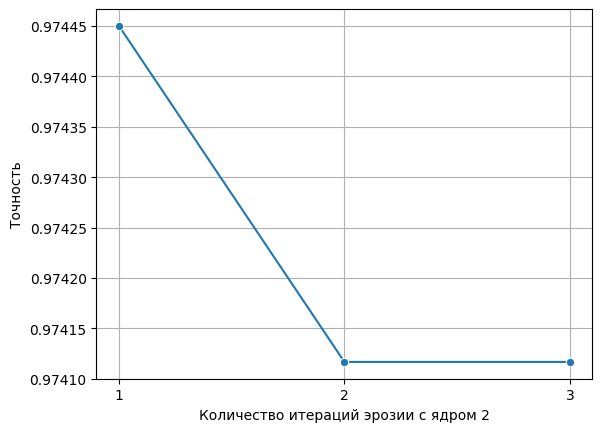

In [42]:
accuracy_exp5 = {disp: {k: np.mean(v) for k, v in values.items()} for disp, values in dict_erode.items()}
accuracy_exp5 = pd.DataFrame(accuracy_exp5)
accuracy_exp5.index.name = 'k'

accuracies = accuracy_exp5.iloc[0]
disps = accuracy_exp5.columns
sns.lineplot(x=disps, y=accuracies, marker='o')
plt.xlabel('Количество итераций эрозии с ядром 2')
plt.ylabel('Точность')
plt.xticks([1, 2, 3])
plt.grid(True)
plt.savefig(fname='exper_5_erode_2.pdf')
plt.show()

## **Преобразование - дилатация**

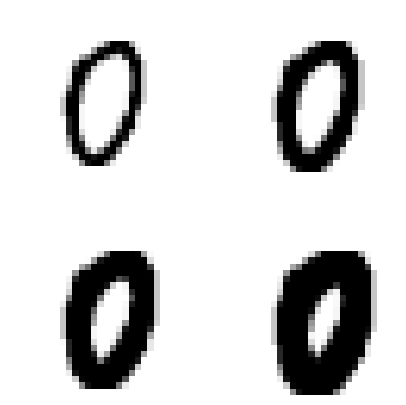

In [36]:
import cv2 as cv

fig, axes = plt.subplots(2, 2, figsize=(5, 5))

kernel = np.ones((2, 2), np.uint8)

for i, ax in enumerate(axes.flat):
    if i == 0:
        ax.imshow(X_train[1000].reshape(28, 28), cmap='gray_r')
    else:
        ax.imshow(cv.dilate(X_train[1000].reshape(28, 28), kernel, iterations = i), cmap='gray_r')
    ax.axis('off')

plt.savefig(fname='exper_5_dilate.pdf')


plt.show()

In [39]:
import cv2 as cv

dict_dilate = dict()

kernel = np.ones((2, 2), np.uint8)
for iteration in tqdm.tqdm(range(1, 4)):
    dict_dilate[iteration] = knn_value_score_augment(X_train, y_train, k_list=[4],
                                           augment_func = (lambda x: (cv.dilate(x.reshape(28, 28), kernel, iterations = iteration).reshape(784))),
                                           score='accuracy', strategy='brute', weights=True,
                                           metric='cosine', test_block_size=10000)

100%|██████████| 3/3 [11:01<00:00, 220.40s/it]


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


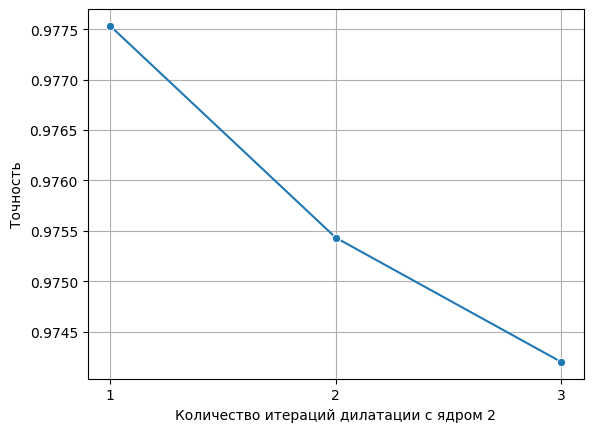

In [41]:
accuracy_exp5 = {disp: {k: np.mean(v) for k, v in values.items()} for disp, values in dict_dilate.items()}
accuracy_exp5 = pd.DataFrame(accuracy_exp5)
accuracy_exp5.index.name = 'k'

accuracies = accuracy_exp5.iloc[0]
disps = accuracy_exp5.columns
sns.lineplot(x=disps, y=accuracies, marker='o')
plt.xlabel('Количество итераций дилатации с ядром 2')
plt.xticks([1, 2, 3])
plt.ylabel('Точность')

plt.grid(True)
plt.savefig(fname='exper_5_dilate_2.pdf')
plt.show()

## **Преобразование - открытие с ядром 2**

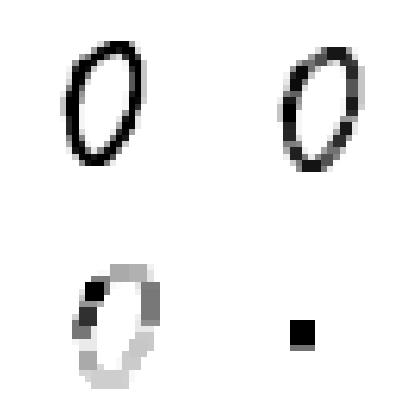

In [47]:
import cv2 as cv

fig, axes = plt.subplots(2, 2, figsize=(5, 5))

kernel = np.ones((2, 2), np.uint8)

for i, ax in enumerate(axes.flat):
    if i == 0:
        ax.imshow(X_train[1000].reshape(28, 28), cmap='gray_r')
    else:
        ax.imshow(cv.morphologyEx(X_train[1000].reshape(28, 28), cv.MORPH_OPEN, kernel, iterations=i), cmap='gray_r')
    ax.axis('off')

plt.savefig(fname='exper_5_open.pdf')


plt.show()

In [48]:
import cv2 as cv

dict_open = dict()

kernel = np.ones((2, 2), np.uint8)
for iteration in tqdm.tqdm(range(1, 3)):
    dict_open[iteration] = knn_value_score_augment(X_train, y_train, k_list=[4],
                                           augment_func = (lambda x: (cv.morphologyEx(x.reshape(28, 28), cv.MORPH_OPEN, kernel, iterations = iteration).reshape(784))),
                                           score='accuracy', strategy='brute', weights=True,
                                           metric='cosine', test_block_size=10000)

100%|██████████| 2/2 [07:31<00:00, 225.59s/it]


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


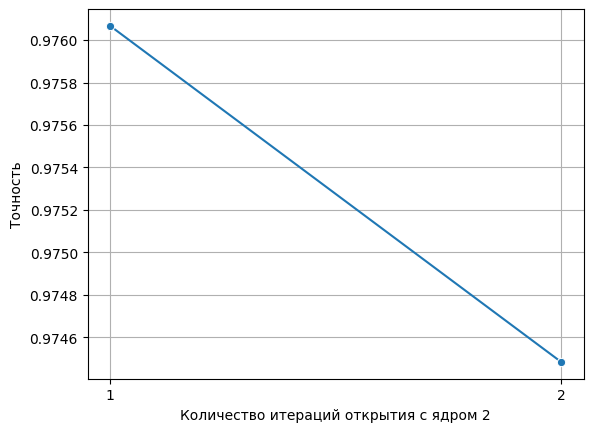

In [49]:
accuracy_exp5 = {disp: {k: np.mean(v) for k, v in values.items()} for disp, values in dict_open.items()}
accuracy_exp5 = pd.DataFrame(accuracy_exp5)
accuracy_exp5.index.name = 'k'

accuracies = accuracy_exp5.iloc[0]
disps = accuracy_exp5.columns
sns.lineplot(x=disps, y=accuracies, marker='o')
plt.xlabel('Количество итераций открытия с ядром 2')
plt.xticks([1, 2])
plt.ylabel('Точность')

plt.grid(True)
plt.savefig(fname='exper_5_open_2.pdf')
plt.show()

## **Преобразование - закрытие с ядром 2**

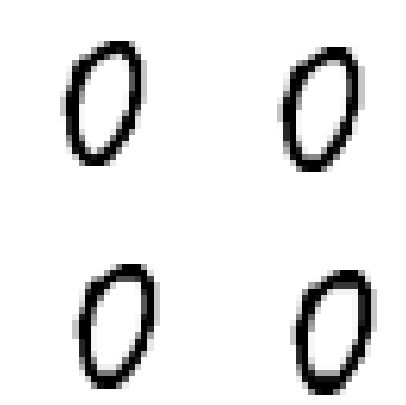

In [50]:
import cv2 as cv

fig, axes = plt.subplots(2, 2, figsize=(5, 5))

kernel = np.ones((2, 2), np.uint8)

for i, ax in enumerate(axes.flat):
    if i == 0:
        ax.imshow(X_train[1000].reshape(28, 28), cmap='gray_r')
    else:
        ax.imshow(cv.morphologyEx(X_train[1000].reshape(28, 28), cv.MORPH_CLOSE, kernel, iterations=i), cmap='gray_r')
    ax.axis('off')

plt.savefig(fname='exper_5_close.pdf')


plt.show()

In [51]:
import cv2 as cv

dict_close = dict()

kernel = np.ones((2, 2), np.uint8)
for iteration in tqdm.tqdm(range(1, 3)):
    dict_close[iteration] = knn_value_score_augment(X_train, y_train, k_list=[4],
                                           augment_func = (lambda x: (cv.morphologyEx(x.reshape(28, 28), cv.MORPH_CLOSE, kernel, iterations = iteration).reshape(784))),
                                           score='accuracy', strategy='brute', weights=True,
                                           metric='cosine', test_block_size=10000)

100%|██████████| 2/2 [07:30<00:00, 225.19s/it]


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


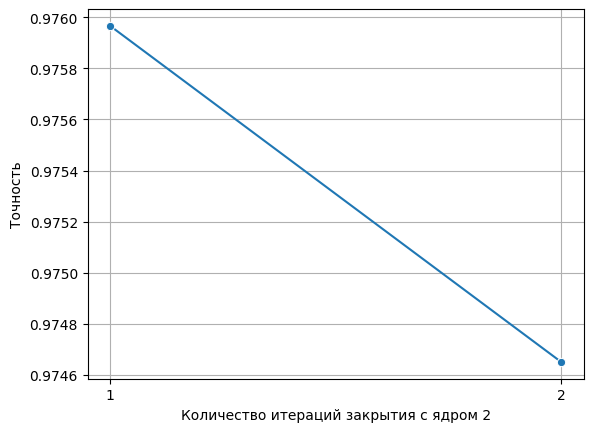

In [52]:
accuracy_exp5 = {disp: {k: np.mean(v) for k, v in values.items()} for disp, values in dict_close.items()}
accuracy_exp5 = pd.DataFrame(accuracy_exp5)
accuracy_exp5.index.name = 'k'

accuracies = accuracy_exp5.iloc[0]
disps = accuracy_exp5.columns
sns.lineplot(x=disps, y=accuracies, marker='o')
plt.xlabel('Количество итераций закрытия с ядром 2')
plt.xticks([1, 2])
plt.ylabel('Точность')

plt.grid(True)
plt.savefig(fname='exper_5_close_2.pdf')
plt.show()

## **Итоговый эксперимент на обучающей и тестовой выборке**

In [15]:
from skimage.transform import rotate
from skimage.transform import warp, AffineTransform
import cv2 as cv


# поворот
X_aug = np.concatenate((np.apply_along_axis((lambda x: rotate(x.reshape(28, 28), angle=10).reshape(784)),
                                            arr=X_train, axis=1), X_train), axis=0)
y_aug = np.concatenate((y_train, y_train), axis=0)
print("Аугментирован поворот")
# смещение
X_aug = np.concatenate((np.apply_along_axis((lambda x: warp(x.reshape(28, 28),
                                            AffineTransform(translation=(-1, 0))).reshape(784)),
                                            arr=X_train, axis=1), X_aug), axis=0)
y_aug = np.concatenate((y_aug, y_train), axis=0)
print("Аугментировано смещение")
# фильтр Гаусса
X_aug = np.concatenate((np.apply_along_axis((lambda x: cv.GaussianBlur(x.reshape(28, 28), (3, 3), sigmaX=1).reshape(784)),
                                            arr=X_train, axis=1), X_aug), axis=0)
y_aug = np.concatenate((y_aug, y_train), axis=0)
print("Аугментирован фильтр Гаусса")
# эрозия
kernel = np.ones((2, 2), np.uint8)
X_aug = np.concatenate((np.apply_along_axis((lambda x: cv.erode(x.reshape(28, 28), kernel, iterations=1).reshape(784)),
                                            arr=X_train, axis=1), X_aug), axis=0)
y_aug = np.concatenate((y_aug, y_train), axis=0)
print("Аугментирован эрозия")
# дилатация
X_aug = np.concatenate((np.apply_along_axis((lambda x: (cv.dilate(x.reshape(28, 28), kernel, iterations = 1).reshape(784))),
                                            arr=X_train, axis=1), X_aug), axis=0)
y_aug = np.concatenate((y_aug, y_train), axis=0)
print("Аугментирована дилатация")
# открытие
X_aug = np.concatenate((np.apply_along_axis((lambda x: (cv.morphologyEx(x.reshape(28, 28),
                                            cv.MORPH_OPEN, kernel, iterations = 1).reshape(784))),
                                            arr=X_train, axis=1), X_aug), axis=0)
y_aug = np.concatenate((y_aug, y_train), axis=0)
print("Аугментировано открытие")
# закрытие
X_aug = np.concatenate((np.apply_along_axis((lambda x: (cv.morphologyEx(x.reshape(28, 28),
                                                                        cv.MORPH_CLOSE, kernel, iterations = 1).reshape(784))),
                                            arr=X_train, axis=1), X_aug), axis=0)
y_aug = np.concatenate((y_aug, y_train), axis=0)
print("Аугментировано закрытие")

model = KNNClassifier(k=4, strategy='brute', weights=True,
                      metric='cosine', test_block_size=10000)
model.fit(X_aug, y_aug)
y_pred = model.predict(X_test)

print(f"Accuracy = {np.sum(y_pred == y_test)/len(y_test)}")

Аугментирован поворот
Аугментировано смещение
Аугментирован фильтр Гаусса
Аугментирован эрозия
Аугментирована дилатация
Аугментировано открытие
Аугментировано закрытие
Accuracy = 0.9836


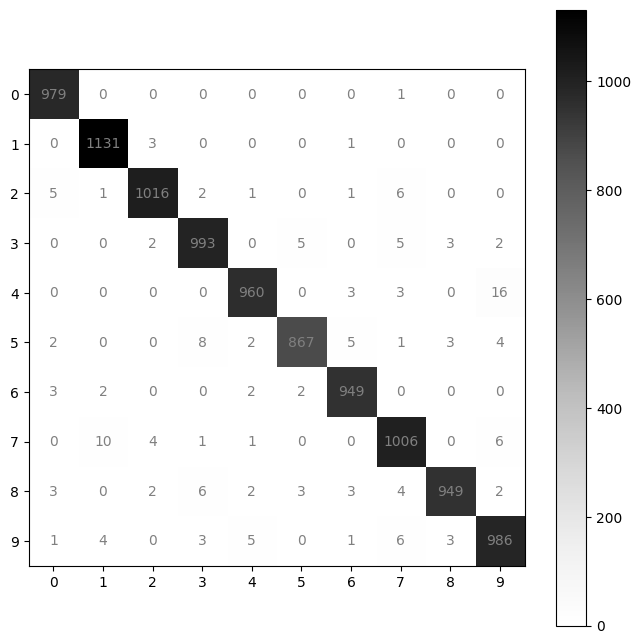

In [16]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,8))
plt.subplot(1, 1, 1)
plt.imshow(conf_matrix, cmap="Greys")

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='grey')

plt.xticks(range(0, 10))
plt.yticks(range(0, 10))
plt.colorbar()
plt.savefig(fname='exper_5_conf.pdf')
plt.show()

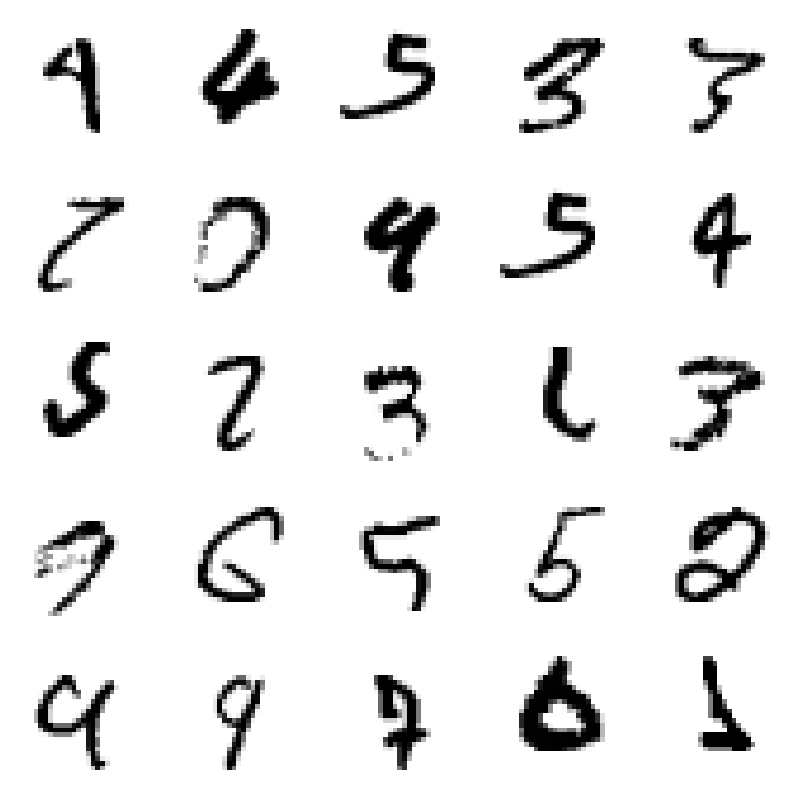

In [17]:
error_images = X_test[y_pred != y_test]

random_errors = error_images[np.random.randint(0, len(error_images), 25)]

fig, axes = plt.subplots(5, 5, figsize=(10, 10))


for i, ax in enumerate(axes.flat):
    ax.imshow(random_errors[i].reshape(28, 28), cmap='gray_r')
    ax.axis('off')

plt.savefig(fname='exper_5_numb.pdf')
plt.show()

# **Эксперимент №6: Применение обучения аугментаций для исправления ошибок**

Реализуйте описанный выше алгоритм, основанный на преобразовании объектов тестовой выборки. Проверьте то же самое множество параметров, что и в предыдущем пункте. Проанализируйте как изменилась матрица ошибок, какие ошибки алгоритма помогает исправить каждое преобразование. Качественно сравните два  подхода (5 и 6 пункты) между собой.

In [38]:
from skimage.transform import rotate
from skimage.transform import warp, AffineTransform
import cv2 as cv


# поворот
X_test_aug = np.concatenate((np.apply_along_axis((lambda x: rotate(x.reshape(28, 28), angle=-10).reshape(784)),
                                            arr=X_test, axis=1), X_test), axis=0)
print("Аугментирован поворот")
# смещение
X_test_aug = np.concatenate((np.apply_along_axis((lambda x: warp(x.reshape(28, 28),
                                            AffineTransform(translation=(1, 0))).reshape(784)),
                                            arr=X_test, axis=1), X_test_aug), axis=0)
print("Аугментировано смещение")
# фильтр Гаусса
X_test_aug = np.concatenate((np.apply_along_axis((lambda x: cv.GaussianBlur(x.reshape(28, 28), (3, 3), sigmaX=1).reshape(784)),
                                            arr=X_test, axis=1), X_test_aug), axis=0)
print("Аугментирован фильтр Гаусса")
# эрозия
kernel = np.ones((2, 2), np.uint8)
X_test_aug = np.concatenate((np.apply_along_axis((lambda x: cv.erode(x.reshape(28, 28), kernel, iterations=1).reshape(784)),
                                            arr=X_test, axis=1), X_test_aug), axis=0)
print("Аугментирована эрозия")
# дилатация
X_test_aug = np.concatenate((np.apply_along_axis((lambda x: (cv.dilate(x.reshape(28, 28), kernel, iterations = 1).reshape(784))),
                                            arr=X_test, axis=1), X_test_aug), axis=0)
print("Аугментирована дилатация")
# открытие
X_test_aug = np.concatenate((np.apply_along_axis((lambda x: (cv.morphologyEx(x.reshape(28, 28),
                                            cv.MORPH_OPEN, kernel, iterations = 1).reshape(784))),
                                            arr=X_test, axis=1), X_test_aug), axis=0)
print("Аугментировано открытие")
# закрытие
X_test_aug = np.concatenate((np.apply_along_axis((lambda x: (cv.morphologyEx(x.reshape(28, 28),
                                                                        cv.MORPH_CLOSE, kernel, iterations = 1).reshape(784))),
                                            arr=X_test, axis=1), X_test_aug), axis=0)
print("Аугментировано закрытие")

model = KNNClassifier(k=4, strategy='brute', weights=True,
                      metric='cosine', test_block_size=10000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test_aug)


Аугментирован поворот
Аугментировано смещение
Аугментирован фильтр Гаусса
Аугментирована эрозия
Аугментирована дилатация
Аугментировано открытие
Аугментировано закрытие


In [40]:
y_vote = y_pred.reshape(8, 10000).T
print(y_vote)

[['7' '7' '7' ... '7' '7' '7']
 ['2' '2' '2' ... '2' '2' '2']
 ['7' '7' '1' ... '1' '1' '1']
 ...
 ['4' '4' '4' ... '4' '4' '4']
 ['5' '5' '8' ... '5' '5' '5']
 ['6' '6' '6' ... '6' '6' '6']]


In [42]:
def predict_class_in_row(row):
    values, counts = np.unique(row, return_counts=True)
    index_class = np.argmax(counts)
    return values[index_class]

y_pred_aug = np.apply_along_axis(
    predict_class_in_row, axis=1, arr=y_vote)
print(f"Accuracy = {np.sum(y_pred_aug == y_test)/len(y_test)}")

Accuracy = 0.9741
